In [1]:
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot

In [2]:
eye(T::Type, n) = Diagonal{T}(I, n)
eye(n) = eye(Float64, n)
vec(X) = vcat(X...)

vec (generic function with 1 method)

In [3]:
n = 4 # number of dims
i = 0.25 # kgm^2, 
b = 0.2 # kgm^2/s
ta = 0.03 # s
te = 0.04 # s
L0 = 0.35 # m

bu = 1 / (ta * te * i)
α1 = bu * b
α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
α3 = b/i + 1/ta + 1/te

A = [zeros(3) eye(3); -[0, α1, α2, α3]']
B = [zeros(3); bu]
C = [eye(3) zeros(3)]
D = Diagonal([1e-3, 1e-2, 5e-2])

Y = 0.02 * B
G = 0.03 * eye(n)

Q = Diagonal([1.0, 0.01, 0, 0]) 
R = 0.0001
U = Diagonal([1.0, 0.1, 0.01, 0]);

In [4]:
maxiter = 1000
eps = 1e-8

# initialize
L = rand(n)' # Feedback gains
K = rand(n, 3) # Kalman gains
I2n = eye(2n)

8×8 Diagonal{Float64, Vector{Float64}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

In [5]:
Ā = [A-B*L B*L; zeros(size(A)) (A-K*C)]
Ȳ = [-ones(2) ones(2)] ⊗ (Y*L) 
Ḡ = [G zeros(size(K)); G (-K*D)]
V = BlockDiagonal([Q, U]) + [1 -1; -1 1] ⊗ (L'* R * L)

8×8 Matrix{Float64}:
  1.00008      5.35731e-5   3.4036e-5   …  -3.4036e-5   -7.88671e-5
  5.35731e-5   0.0100364    2.31062e-5     -2.31062e-5  -5.35409e-5
  3.4036e-5    2.31062e-5   1.46798e-5     -1.46798e-5  -3.40156e-5
  7.88671e-5   5.35409e-5   3.40156e-5     -3.40156e-5  -7.88197e-5
 -7.89146e-5  -5.35731e-5  -3.4036e-5       3.4036e-5    7.88671e-5
 -5.35731e-5  -3.63694e-5  -2.31062e-5  …   2.31062e-5   5.35409e-5
 -3.4036e-5   -2.31062e-5  -1.46798e-5      0.0100147    3.40156e-5
 -7.88671e-5  -5.35409e-5  -3.40156e-5      3.40156e-5   7.88197e-5

In [6]:
# update S, P
S = reshape((I2n' ⊗ Ā' +  Ā' ⊗ I2n + Ȳ' ⊗  Ȳ')^-1 * vec(-V), (2n, 2n))
P = reshape((I2n' ⊗ Ā +  Ā ⊗ I2n + Ȳ ⊗  Ȳ)^-1 * vec(-Ḡ * Ḡ'), (2n, 2n))

8×8 Matrix{Float64}:
 -0.0043363    -0.00045      0.0130636    …   4.2659e-5     0.00175731
 -0.00045      -0.0130636   -0.00045         -0.00112376    0.00136219
  0.0130636    -0.00045     -0.0158293       -0.000331409   0.000517776
  0.00045       0.0158293   -0.00045         -0.00125144   -0.0420502
  0.00359664    0.00174798   8.86964e-5      -0.000902572   0.000993477
 -0.000212652   0.00136089   0.000328134  …  -0.00104695   -0.000144896
  4.2659e-5    -0.00112376  -0.000331409      0.000832721  -0.00122277
  0.00175731    0.00136219   0.000517776     -0.00122277   -0.0387205

In [7]:
# update K, L
P22 = P[n+1:2n, n+1:2n]
S11 = S[1:n, 1:n]
S22 = S[n+1:2n, n+1:2n]

4×4 Matrix{Float64}:
 -1.22162     -0.134135     1.2575       0.00154696
 -0.134135    -1.7815      -1.4152       0.00333555
  1.2575      -1.4152      -1.15814     -0.00117737
  0.00154696   0.00333555  -0.00117737  -1.92159e-6

In [8]:
Ktm1 = copy(K)
Ltm1 = copy(L)

1×4 adjoint(::Vector{Float64}) with eltype Float64:
 0.888339  0.603071  0.383142  0.887805

In [9]:
K = P22 * C' * (D * D')^-1
L = (R + Y' * (S11 + S22) * Y)^-1 * B' * S11

1×4 adjoint(::Vector{Float64}) with eltype Float64:
 -50.8196  75.8725  106.179  0.176813

In [10]:
for i in 1:maxiter
    Ā = [A-B*L B*L; zeros(size(A)) (A-K*C)]
    Ȳ = [-ones(2) ones(2)] ⊗ (Y*L) 
    Ḡ = [G zeros(size(K)); G (-K*D)]
    V = BlockDiagonal([Q, U]) + [1 -1; -1 1] ⊗ (L'* R * L)
    
    # update S, P
    S = -reshape((I2n' ⊗ Ā' +  Ā' ⊗ I2n + Ȳ' ⊗  Ȳ')^-1 * vec(V), (2n, 2n))
    P = -reshape((I2n' ⊗ Ā +  Ā ⊗ I2n + Ȳ ⊗  Ȳ)^-1 * vec(Ḡ * Ḡ'), (2n, 2n))

    # update K, L
    P22 = P[n+1:2n, n+1:2n]
    S11 = S[1:n, 1:n]
    S22 = S[n+1:2n, n+1:2n]

    Ktm1 = copy(K)
    Ltm1 = copy(L)

    K = P22 * C' * (D * D')^-1
    L = (R + Y' * (S11 + S22) * Y)^-1 * B' * S11
    if sum(abs.(K - Ktm1)) < eps && sum(abs.(L - Ltm1)) < eps
        break
    end
end

In [11]:
dt = 0.001 # sec
T = 2.0 # sec
nt = round(Int, T/dt)
Xa = zeros(4, nt)
ua = zeros(nt)
Xa[1, 1] = -0.5 # m; initial position (target position is zero)

for k=1:nt-1
    ua[k] = -L * Xa[:, k]
    Xa[:, k+1] = Xa[:,k] + (A * Xa[:,k] + B * ua[k]) * dt
end

In [12]:
sqrtdt = √dt
nsim = 10
XSimAll = zeros(nsim, 4, nt)
uSimAll = zeros(nsim, nt)
for i in 1:nsim
    XSim = zeros(4, nt)
    Xhat = zeros(4, nt)
    u = zeros(nt)
    XSim[1, 1] = -0.5 # m; initial position (target position is zero)
    Xhat[1, 1] = XSim[1, 1]
    
    for k=1:nt-1
        u[k] = -L * Xhat[:, k]
        XSim[:, k+1] = XSim[:,k] + (A * XSim[:,k] + B * u[k]) * dt + sqrtdt * (Y * u[k] * randn() + G * randn(n))
        dy = C * XSim[:,k] * dt + D * sqrtdt * randn(n-1)
        Xhat[:, k+1] = Xhat[:,k] + (A * Xhat[:,k] + B * u[k]) * dt + K * (dy - C * Xhat[:,k] * dt)
    end
    XSimAll[i,:,:] = XSim
    uSimAll[i, :] = u
end

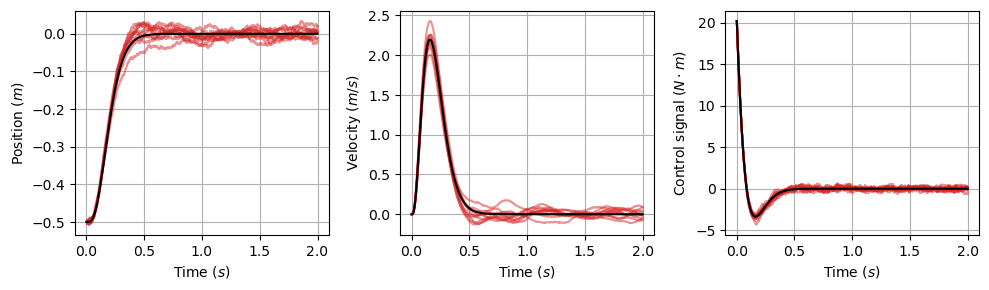

In [13]:
tarray = (1:nt) * dt
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]
figure(figsize=(10, 3))
for i in 1:2
    subplot(1,3,i)
    plot(tarray, XSimAll[:,i,:]', "tab:red", alpha=0.5)
    plot(tarray, Xa[i,:], "k")
    ylabel(label[i]); grid()
    xlabel(L"Time ($s$)")
end
subplot(1,3,3)
plot(tarray, uSimAll', "tab:red", alpha=0.5)
plot(tarray, ua, "k")
ylabel(L"Control signal ($N\cdot m$)"); grid()
xlabel(L"Time ($s$)")
tight_layout()